# SHARK QUEST
## New Kids On The Block



# TODO

- Pickle ?
- Column names?

## Selecting
- Select relevant columns
- Analyse relevant columns

## Cleaning :
- Cast to appropriate data types
    - General cleaning
        - identify duplicates
            - fuzzy
        - removing duplicates
            - remove
            - merge
        - handling null values
            - remove
            - replace
        - manipulating strings
        - formatting the data.

- Wrong inputs
- Outliers

## Hypothesis

### TIME
- Shark attacks are seasonal (Summer)
- Shark attacks are increasing 
- Shark attacks are more concentrated in the PM 

### LOCATION
- Some countries are more attack prone (Australia)
- Some countries are more likely to be fatal (Australia)


### DEMOGRAPHICS
- Males are more likely to get attacked
- Males are more likely to get provoke a shark
- Provoked attacked are more fatal
- Young persons are more likely to get attacked
- Old persons are more likely to get killed

- Names more likely to get attacked (John)

### OTHER
- Some species are more aggressive (Tiger Shark)
- Some activities are more likely (Surfing)
- Some activities are more fatal

- Full moon? 😂


Retained :
- Shark Species have a gender preference (score) => JP => Heinning
- Some countries are more provocative against sharks* => Ricardo
- Shark attacks are more concentrated in the PM => Linh

- Names more likely to get attacked (John) => JP?

## Business Ideas

- App that gives a likelyhood of attack based on location and time
- Vacations far away from sharks for phobics
- Witness attacks for masochists

- Surf school at the safest places / seasons
- Fishing supplies => shark repellant by activities
- Safety training to avoid provocations / live in harmony

- Shark repellant => best spots
- Insurance for surfers, premiums for high risk areas

### GENERAL CLEANING
1. Rename columns
2. Drop columns
3. Remove duplicates
    - Remove full dupes
    - Remove fuzzy search
4. Strip values
5. Reset Index

### SPECIFIC CLEANING
1. Search / Replace / Reformat strings
2. Merge categories
3. Cast to Null
4. Cast correct type
5. Create new columns


In [29]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#import depedencies
#from shapely.geometry import Point
import pandas as pd
import numpy as np
import re
import json
#import geopandas as gpd
import matplotlib.pyplot as plt
from cleaning import *


In [31]:
# Load the data
shark_attacks_df = pd.read_excel('GSAF5.xls')
shark_attacks = shark_attacks_df.copy()

countries_df = pd.read_csv('country_coord.csv')
countries = countries_df.copy()

shark_attacks.head()



,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,15 Mar 2024,2024.0,Unprovoked,AUSTRALIA,Queensland,Bargara Beach,Swimming,Brooklyn Sauer,F,13,...,Tiger shark,"Yahoo News, 3/15/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04 Mar 2024,2024.0,Unprovoked,USA,Hawaii,"Old Man's, Waikiki",Surfing,Matthew White,M,NaN,...,Tiger shark 8',"Surfer, 3/6/2024F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02 Mar-2024,2024.0,Unprovoked,USA,Hawaii,"Rainbows, Oahu",Swimming,NaN,F,11,...,3' to 4' shark,"Hawaii News Now, 3/4/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25 Feb-2024,2024.0,Unprovoked,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",NaN,female,F,46,...,Tiger shark,"WA Today, 2/26/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14 Feb-2024,2024.0,Unprovoked,INDIA,Maharashtra,"Vaitarna River, Palghar District",Fishing,Vicky Suresh Govari,M,32,...,"Bull shark, 7'","Times of India, 2/14/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Settings
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 100)

In [33]:
# Format all columns names
shark_attacks.columns = [col.strip().replace(" ", "_").replace(".", "").lower() for col in shark_attacks.columns]

In [34]:

# Functions

def merge_values(row, arg1, *args):
    if row in args:
        return arg1
    else:
        return row


def strip_values(df):
    for col in df.columns:
        df[col] = df[col].apply(
            lambda x: x.strip() if isinstance(x, str) else x)
    return df


def replace_to_nan(series, keys, value=np.nan):
    """
    input series as dataframe['Column']
    input keys as a list of all the keys to replace
    input value as the replacer value for the keys, default is NaN
    """

    return series.replace(keys, value, inplace=True)


def categorize_activity(activity):
    if pd.isna(activity):
        return "Invalid"

    activity = activity.lower()

    for pattern, label in categories:
        if re.search(pattern, activity):
            return label

    return "Other Activity"


def replace_string_patterns(value, replacements):

    if isinstance(value, str):

        for pattern, result in replacements:
            value = re.sub(pattern, result, value)
        return value

    else:

        return value
    
def json_to_dict(json_filename):
    with open(json_filename+".json", "r") as json_file:
        data = json.load(json_file)
    return data


In [35]:
# Contract

data_schema = json_to_dict('schema')

""" data_schema_in = {
    'type': {'dtype': 'category', 'categories': ['PROVOKED', 'UNPROVOKED', 'WATERCRAFT','INVALID']},
    'date': {'dtype': 'datetime64[ns]'},
    'country': {'dtype': 'string'},
    'state': {'dtype': 'string'},
    'location': {'dtype': 'string'},
    'activity': {'dtype': 'category', 'categories': ['SWIMMING', 'SURFING', 'FISHING', 'DIVING', 'PASSIVE', 'BOATING']},
    'severity': {'dtype': 'category', 'categories': ['FATALITY', 'INJURY', 'OTHER']},
    'time': {'dtype': 'category', 'categories': ['MORNING', 'NOON', 'AFTERNOON', 'DANW', 'NIGHT', 'DUSK']}
} """



" data_schema_in = {\n    'type': {'dtype': 'category', 'categories': ['PROVOKED', 'UNPROVOKED', 'WATERCRAFT','INVALID']},\n    'date': {'dtype': 'datetime64[ns]'},\n    'country': {'dtype': 'string'},\n    'state': {'dtype': 'string'},\n    'location': {'dtype': 'string'},\n    'activity': {'dtype': 'category', 'categories': ['SWIMMING', 'SURFING', 'FISHING', 'DIVING', 'PASSIVE', 'BOATING']},\n    'severity': {'dtype': 'category', 'categories': ['FATALITY', 'INJURY', 'OTHER']},\n    'time': {'dtype': 'category', 'categories': ['MORNING', 'NOON', 'AFTERNOON', 'DANW', 'NIGHT', 'DUSK']}\n} "

In [36]:
#Creating new columns
shark_attacks['severity'] = shark_attacks_df['Injury']

In [37]:
# Selecting columns
shark_attacks = shark_attacks[[col for col in data_schema]]
shark_attacks['species'].value_counts()


species
White shark                                                                                                                      194
Shark involvement prior to death was not confirmed                                                                               105
Invalid                                                                                                                          102
Shark involvement not confirmed                                                                                                   92
Tiger shark                                                                                                                       89
                                                                                                                                ... 
1.2 m to 1.8 m [4' to 6'] shark                                                                                                    1
Grey nurse shark, 3 m female                                 

In [38]:
# Strip strings
shark_attacks = shark_attacks.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [39]:
#Handling missing values
shark_attacks.replace(['N/A', 'null', '--'], np.nan, inplace=True)

In [40]:
#Remove duplicates
#Drop complete duplicates
shark_attacks.drop_duplicates(keep=False, inplace=True)

In [41]:
#Reset Index
shark_attacks.reset_index(inplace=True)

In [42]:
# Reformat values
replacements = json_to_dict('replacements')

r""" replacements_in = {
    
    'type': [
        (r'^.*?(Provoked).*$', 'PROVOKED'),
        (r'^.*?(Unprovoked|Disaster).*$', 'UNPROVOKED'),
        (r'^.*?(Watercraft|Boat).*$', 'WATERCRAFT'),
    ],

    'activity': [
        (r'^.*?([Ss]wimming|[Ww]ading|[Bb]athing|[Ff]el|[Ss]plashing|[Ff]loat|[Dd]isaster|Dangling|Jump).*$', 'SWIMMING'),
        (r'^.*?([Sf]urf|[Bb]oard|[Pp]addl|[Ff]oil).*$', 'SURFING'),
        (r'^.*?([Dd]iving|[Ss]cuba|[Ss]norkel|[Sp]ear|[Ww]reck).*$', 'DIVING'),
        (r'^.*?([Bb]oat|[Sa]il|[Rr]ow|[Cc]raft|[Kk]ayak|[Cc]ano).*$', 'BOATING'),
        (r'^.*?(Fishing|Clam).*$', 'FISHING'),
        (r'^.*?([Ss]it|[Ss]tand|[Pp]lay|Murder|[Tt]read|[Ww]alk).*$', 'PASSIVE'),
    ],
    
    'time': [
        (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),
        (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),
        (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\.?[mM])).*$', 'MORNING'),
        (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),
        (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\.?[mM])).*$', 'AFTERNOON'),
        (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening|[Ii]njured)).*$', 'DUSK'),
    ],
    
    'date': [
        (r'^(.*)(\d{2})(.*)(\w{3})(.*)(\d{4})(.*)', r'\2-\4-\6'),
        (r'^(.*)(\w{3})(.*)(\d{4})(.*)', r'01-\2-\4'),
        (r'-(uly|une)', r'-J\1'),
    ],
    
    'severity': [
        (r'^.*([Fa]tal|FATAL|[Kk]illed).*$', r'FATALITY'),
        (r'^.*(^[Ii]nju|[Bb]it|[Ss]urvived|[Ll]acer|[Mm]inor|[Ii]njured|[Aa]bra|[Pp]unct|[Mm]ultiple|[Ss]cratches|[Rr]iped|[Gg]ash).*$', r'INJURY'),
    ],
    
    'country': [
        (r'^.*([Fa]tal|FATAL|[Kk]illed).*$', r'FATALITY'),
    ],
}
 """

" replacements_in = {\n    \n    'type': [\n        (r'^.*?(Provoked).*$', 'PROVOKED'),\n        (r'^.*?(Unprovoked|Disaster).*$', 'UNPROVOKED'),\n        (r'^.*?(Watercraft|Boat).*$', 'WATERCRAFT'),\n    ],\n\n    'activity': [\n        (r'^.*?([Ss]wimming|[Ww]ading|[Bb]athing|[Ff]el|[Ss]plashing|[Ff]loat|[Dd]isaster|Dangling|Jump).*$', 'SWIMMING'),\n        (r'^.*?([Sf]urf|[Bb]oard|[Pp]addl|[Ff]oil).*$', 'SURFING'),\n        (r'^.*?([Dd]iving|[Ss]cuba|[Ss]norkel|[Sp]ear|[Ww]reck).*$', 'DIVING'),\n        (r'^.*?([Bb]oat|[Sa]il|[Rr]ow|[Cc]raft|[Kk]ayak|[Cc]ano).*$', 'BOATING'),\n        (r'^.*?(Fishing|Clam).*$', 'FISHING'),\n        (r'^.*?([Ss]it|[Ss]tand|[Pp]lay|Murder|[Tt]read|[Ww]alk).*$', 'PASSIVE'),\n    ],\n    \n    'time': [\n        (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),\n        (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),\n        (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\\.?[mM])).*$', 'MORNING'),\n        (r'^.*((1[1-4])h.*$|([nN]oon|[

In [43]:

for col, values in replacements.items():
    shark_attacks[col] = shark_attacks[col].apply(
        replace_string_patterns, replacements=values)
shark_attacks['country']

0                AUSTRALIA
1                      USA
2                      USA
3                AUSTRALIA
4                    INDIA
               ...        
6901             AUSTRALIA
6902             AUSTRALIA
6903                   USA
6904                PANAMA
6905    CEYLON (SRI LANKA)
Name: country, Length: 6906, dtype: object

In [44]:
shark_attacks['country'] = shark_attacks['country'].apply(lambda x: x.lower() if isinstance(x, str) else x)
replace_to_nan(shark_attacks["country"], ["england","scotland"], "united kingdom")
replace_to_nan(shark_attacks["country"], ["usa", "hawaii"], "united states")
replace_to_nan(shark_attacks["country"], ["reunion"], "france")
replace_to_nan(shark_attacks["country"], ["columbia"], "colombia")
replace_to_nan(shark_attacks["country"], ["new guinea"], "papua new guinea")


# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
country_list = [x.lower() for x in countries['Country']]
shark_attacks["country"] = shark_attacks["country"].where(shark_attacks["country"].isin(country_list), np.nan)
shark_attacks['country'].value_counts()

country
united states       2524
australia           1475
south africa         598
papua new guinea     146
new zealand          145
                    ... 
guatemala              1
jordan                 1
mayotte                1
gabon                  1
djibouti               1
Name: count, Length: 113, dtype: int64

In [45]:
#Clean dates
shark_attacks['date'] = pd.to_datetime(shark_attacks['date'], errors='coerce')
shark_attacks['date'] = shark_attacks['date'].dt.strftime('%d-%m-%Y')
shark_attacks['date'] = shark_attacks['date'].ffill()

In [46]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
shark_attacks = shark_attacks.astype(columns_types)
shark_attacks.dtypes

index                int64
type              category
date        datetime64[ns]
country     string[python]
state       string[python]
location    string[python]
activity          category
severity          category
time              category
species           category
sex               category
dtype: object

In [47]:
shark_attacks['species'].value_counts()

species
GREAT WHITE SHARK                                               744
TIGER SHARK                                                     334
BULL SHARK                                                      216
BLACKTIP SHARK                                                  139
NURSE SHARK                                                     113
                                                               ... 
5.5' shark                                                        1
15 cm to 20 cm [6" to 8"] bite diameter just below left knee      1
5.5 ft shark                                                      1
15'                                                               1
“small brown shark”                                               1
Name: count, Length: 477, dtype: int64

In [48]:
# Clean categories
for column in shark_attacks.select_dtypes(include=['category']).columns:
    shark_attacks[column] = shark_attacks[column].where(shark_attacks[column].isin(data_schema[column]['categories']), other=np.nan)
    shark_attacks[column] = shark_attacks[column].astype('string')
    shark_attacks[column] = shark_attacks[column].astype('category')
shark_attacks.dtypes
shark_attacks.select_dtypes(include=['category'])

,type,activity,severity,time,species,sex
0,UNPROVOKED,SWIMMING,INJURY,AFTERNOON,TIGER SHARK,FEMALE
1,UNPROVOKED,SURFING,INJURY,<NA>,TIGER SHARK,MALE
2,UNPROVOKED,SWIMMING,INJURY,NOON,<NA>,FEMALE
3,UNPROVOKED,<NA>,INJURY,NOON,TIGER SHARK,FEMALE
4,UNPROVOKED,FISHING,INJURY,<NA>,BULL SHARK,MALE
...,...,...,...,...,...,...
6901,UNPROVOKED,DIVING,FATALITY,<NA>,<NA>,MALE
6902,UNPROVOKED,DIVING,FATALITY,<NA>,<NA>,MALE
6903,UNPROVOKED,SWIMMING,FATALITY,<NA>,<NA>,MALE
6904,UNPROVOKED,<NA>,FATALITY,<NA>,<NA>,MALE


In [49]:
#export to csv
#shark_attacks.to_csv('shark_attacks_cleaned.csv', index=False)
display(shark_attacks)
shark_attacks['species'].unique()

,index,type,date,country,state,location,activity,severity,time,species,sex
0,0,UNPROVOKED,2024-01-03,australia,Queensland,Bargara Beach,SWIMMING,INJURY,AFTERNOON,TIGER SHARK,FEMALE
1,1,UNPROVOKED,2024-01-03,united states,Hawaii,"Old Man's, Waikiki",SURFING,INJURY,<NA>,TIGER SHARK,MALE
2,2,UNPROVOKED,2024-01-03,united states,Hawaii,"Rainbows, Oahu",SWIMMING,INJURY,NOON,<NA>,FEMALE
3,3,UNPROVOKED,2024-01-02,australia,Western Australia,"Sandlnd Island, Jurian Bay",<NA>,INJURY,NOON,TIGER SHARK,FEMALE
4,4,UNPROVOKED,2024-01-02,india,Maharashtra,"Vaitarna River, Palghar District",FISHING,INJURY,<NA>,BULL SHARK,MALE
...,...,...,...,...,...,...,...,...,...,...,...
6901,6939,UNPROVOKED,1913-01-07,australia,Western Australia,Roebuck Bay,DIVING,FATALITY,<NA>,<NA>,MALE
6902,6940,UNPROVOKED,1913-01-07,australia,Western Australia,<NA>,DIVING,FATALITY,<NA>,<NA>,MALE
6903,6941,UNPROVOKED,1913-01-07,united states,North Carolina,Ocracoke Inlet,SWIMMING,FATALITY,<NA>,<NA>,MALE
6904,6942,UNPROVOKED,1913-01-07,panama,<NA>,"Panama Bay 8ºN, 79ºW",<NA>,FATALITY,<NA>,<NA>,MALE


['TIGER SHARK', <NA>, 'BULL SHARK', 'BLACKTIP SHARK', 'GREAT WHITE SHARK', ..., 'COPPER SHARK', 'LEOPARD SHARK', 'CARPET SHARK', 'BONITA SHARK', 'SHOVELNOSE SHARK']
Length: 36
Categories (35, string): [ANGEL SHARK, BASKING SHARK, BLACKTIP SHARK, BLUE SHARK, ..., TIGER SHARK, WHALER SHARK, WOBBEGONG SHARK, ZAMBEZI SHARK]

In [50]:
shark_attacks_clean = shark_attacks.copy()
shark_attacks_clean

,index,type,date,country,state,location,activity,severity,time,species,sex
0,0,UNPROVOKED,2024-01-03,australia,Queensland,Bargara Beach,SWIMMING,INJURY,AFTERNOON,TIGER SHARK,FEMALE
1,1,UNPROVOKED,2024-01-03,united states,Hawaii,"Old Man's, Waikiki",SURFING,INJURY,<NA>,TIGER SHARK,MALE
2,2,UNPROVOKED,2024-01-03,united states,Hawaii,"Rainbows, Oahu",SWIMMING,INJURY,NOON,<NA>,FEMALE
3,3,UNPROVOKED,2024-01-02,australia,Western Australia,"Sandlnd Island, Jurian Bay",<NA>,INJURY,NOON,TIGER SHARK,FEMALE
4,4,UNPROVOKED,2024-01-02,india,Maharashtra,"Vaitarna River, Palghar District",FISHING,INJURY,<NA>,BULL SHARK,MALE
...,...,...,...,...,...,...,...,...,...,...,...
6901,6939,UNPROVOKED,1913-01-07,australia,Western Australia,Roebuck Bay,DIVING,FATALITY,<NA>,<NA>,MALE
6902,6940,UNPROVOKED,1913-01-07,australia,Western Australia,<NA>,DIVING,FATALITY,<NA>,<NA>,MALE
6903,6941,UNPROVOKED,1913-01-07,united states,North Carolina,Ocracoke Inlet,SWIMMING,FATALITY,<NA>,<NA>,MALE
6904,6942,UNPROVOKED,1913-01-07,panama,<NA>,"Panama Bay 8ºN, 79ºW",<NA>,FATALITY,<NA>,<NA>,MALE


In [51]:
shark_attacks['species'].value_counts(dropna=False)


species
<NA>                  4714
GREAT WHITE SHARK      744
TIGER SHARK            334
BULL SHARK             216
BLACKTIP SHARK         139
NURSE SHARK            113
WHALER SHARK            78
REEF SHARK              61
BLUE SHARK              61
MAKO SHARK              57
WOBBEGONG SHARK         55
HAMMERHEAD SHARK        49
RAGGEDTOOTH SHARK       44
LEMON SHARK             44
ZAMBEZI SHARK           30
SANDBAR SHARK           26
SEVENGILL SHARK         24
SPINNER SHARK           24
DUSKY SHARK             12
GREY SHARK              11
GALAPAGOS SHARK          9
CARPET SHARK             8
ANGEL SHARK              7
BASKING SHARK            7
PORBEAGLE SHARK          6
COOKIECUTTER SHARK       6
COPPER SHARK             5
SALMON SHARK             4
SILKY SHARK              4
SHOVELNOSE SHARK         3
THRESHER SHARK           3
GOBLIN SHARK             2
COW SHARK                2
LEOPARD SHARK            2
EPAULETTE SHARK          1
BONITA SHARK             1
Name: count, dtype: 

In [78]:
time_counts = shark_attacks['time'].value_counts()
time_counts


time
NOON         1314
AFTERNOON     941
MORNING       761
DUSK          179
NIGHT         102
DAWN           82
Name: count, dtype: int64

In [82]:

df_time = pd.DataFrame(
    {'Time Category': time_counts.index,
     'Number of Attacks': time_counts.values  
    }
)
df_time

,Time Category,Number of Attacks
0,NOON,1314
1,AFTERNOON,941
2,MORNING,761
3,DUSK,179
4,NIGHT,102
5,DAWN,82


/var/folders/9z/k5tvnzx17sb0wxf4lrs5qkwm0000gp/T/ipykernel_37886/1071584036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')


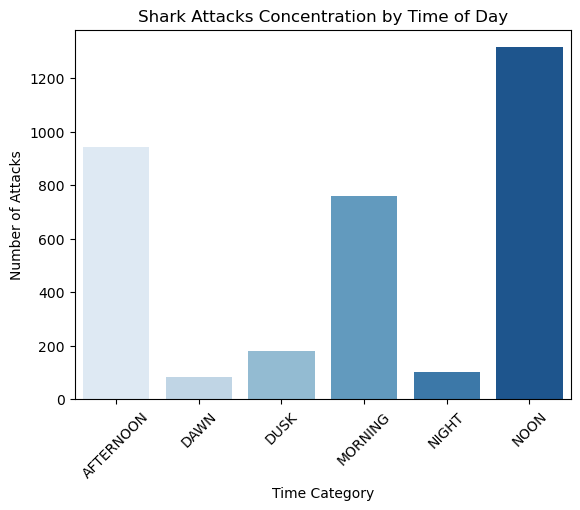

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')
plt.title('Shark Attacks Concentration by Time of Day')
plt.xlabel('Time Category')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Conclusion: we could easily determine that shark attacks are most concentrated during NOON based on the dataset.

# ARCHIVE

In [53]:
# Hennings functions
# Merge categories : (*categories to be merged, target) - Henning


""" shark_attacks['type'] = shark_attacks['type'].apply(merge_values, args=(
    "Invalid", "Questionable", "Unconfirmed", "?", 'Unverified', 'Under investigation'))
shark_attacks['type'] = shark_attacks['type'].apply(
    merge_values, args=("Provoked", " Provoked"))
shark_attacks['type'] = shark_attacks['type'].apply(
    merge_values, args=("Watercraft", "Boat"))  """


' shark_attacks[\'type\'] = shark_attacks[\'type\'].apply(merge_values, args=(\n    "Invalid", "Questionable", "Unconfirmed", "?", \'Unverified\', \'Under investigation\'))\nshark_attacks[\'type\'] = shark_attacks[\'type\'].apply(\n    merge_values, args=("Provoked", " Provoked"))\nshark_attacks[\'type\'] = shark_attacks[\'type\'].apply(\n    merge_values, args=("Watercraft", "Boat"))  '

In [54]:
# Linh functions
# Strip function : strips spaces - Linh


In [55]:
""" df_cleaned['location'] = df_cleaned['location'].astype(str)


def clean_data(location):
    location = re.sub(r'\d{1,2}º[NS],\s*\d{1,3}º[EW]', '', location)
    location = re.sub(r'\(.*?\)', '', location)
    location = re.sub(r'\s+', ' ', location)
    return location.title()


df_cleaned['location'] = df_cleaned['location'].apply(clean_data)
df_cleaned['location'].head(1000) """

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/9z/k5tvnzx17sb0wxf4lrs5qkwm0000gp/T/ipykernel_37886/1494568874.py:1: SyntaxWarning: invalid escape sequence '\d'
  """ df_cleaned['location'] = df_cleaned['location'].astype(str)


" df_cleaned['location'] = df_cleaned['location'].astype(str)\n\n\ndef clean_data(location):\n    location = re.sub(r'\\d{1,2}º[NS],\\s*\\d{1,3}º[EW]', '', location)\n    location = re.sub(r'\\(.*?\\)', '', location)\n    location = re.sub(r'\\s+', ' ', location)\n    return location.title()\n\n\ndf_cleaned['location'] = df_cleaned['location'].apply(clean_data)\ndf_cleaned['location'].head(1000) "

In [56]:
""" categories = [
    (r"swimming|wading", "Swimming"),
    (r"surf|boogie boarding|paddle|foil", "Surfing"),
    (r"fish|fishing|spearfish|kayak", "Fishing"),
    (r"diving|scuba|freediving|snorkel", "Diving"),
    (r"sit|stand", "Passive"),
] """




""" df_cleaned['activity'] = df_cleaned['activity'].apply(categorize_activity)
df_cleaned.head(100) """

" df_cleaned['activity'] = df_cleaned['activity'].apply(categorize_activity)\ndf_cleaned.head(100) "

In [57]:
# Ricardo functions
# Replace as Nan, Nat, ... function - Ricardo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo



    
""" replace_to_nan(shark_attacks["Name"].fillna(np.nan).str.strip(),['male', 'female'],np.nan)
shark_attacks """

' replace_to_nan(shark_attacks["Name"].fillna(np.nan).str.strip(),[\'male\', \'female\'],np.nan)\nshark_attacks '

In [58]:
# Jp functions

# replacements
""" replacements_test_species = [
    (r'^.*([Tt]iger).*$', 'TIGER SHARK'),
]



replacements_test_time = [
    (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),
    (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),
    (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\.?[mM])).*$', 'MORNING'),
    (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),
    (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\.?[mM])).*$', 'AFTERNOON'),
    (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening)).*$', 'DUSK'),
] """

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/var/folders/9z/k5tvnzx17sb0wxf4lrs5qkwm0000gp/T/ipykernel_37886/68318399.py:4: SyntaxWarning: invalid escape sequence '\.'
  """ replacements_test_species = [


" replacements_test_species = [\n    (r'^.*([Tt]iger).*$', 'TIGER SHARK'),\n]\n\n\n\nreplacements_test_time = [\n    (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),\n    (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),\n    (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\\.?[mM])).*$', 'MORNING'),\n    (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),\n    (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\\.?[mM])).*$', 'AFTERNOON'),\n    (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening)).*$', 'DUSK'),\n] "

In [59]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill
relevant_columns = ['date', 'Year', 'type', 'country', 'state', 'location', 'activity',
                    'Name', 'Sex', 'Age', 'injury', 'time', 'Species', 'Source', 'pdf', 'href formula', 'href']
business_relevant_columns = ['date', 'type', 'country',
                             'state', 'location', 'activity', 'injury', 'time']

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

""" display(time_replace_test.value_counts())
where_test = time_replace_test.where(time_replace_test.isin(valid_categories))
where_test = where_test.astype('category')
where_test """

" display(time_replace_test.value_counts())\nwhere_test = time_replace_test.where(time_replace_test.isin(valid_categories))\nwhere_test = where_test.astype('category')\nwhere_test "

In [60]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill
relevant_columns = ['date', 'Year', 'type', 'country', 'state', 'location', 'activity',
                    'Name', 'Sex', 'Age', 'injury', 'time', 'Species', 'Source', 'pdf', 'href formula', 'href']
business_relevant_columns = ['date', 'type', 'country',
                             'state', 'location', 'activity', 'injury', 'time']

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

# Todo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo

# Functions :
# Merge categories : (*categories to be merged, target) - Henning
# Strip function : strips spaces - Linh
# Replace as Nan, Nat, ... function - Ricardo
# DONE - Replace by keyword function - Jp
# DONE - Cast to dateTime function
# Matching function (find similarities, keyword based?)
# DONE - Reformat dates, strings
# Filter function

In [61]:
shark_attacks['Name'].value_counts()


def get_fname(row):
    return str(row).split()[0]


shark_attacks['first_name'] = shark_attacks['Name'].apply(get_fname)

shark_attacks['first_name'].value_counts().head(50)

KeyError: 'Name'

### INJURY

## Problems
- Some are non-human damages (boat, kayak, boards)
- Some are non injuries (touched shark)
- Some don't have details
- Fatalities flags are non consistent
- Some incident are post-mortem
- Some are not incidents ('Aboriginal rock carving depicts man being attacked by a shark')
- Nan

## Additional
- Some provoked details that could be useful if missing elsewhere

## Solutions
- 3 categories : 
    - Fatality
    - Injury
    - Other

- Keyword(s) based search / replace ?

### TIME

## Problems
- Lots of Nan
- Some are times (12h00,...), other are time of day (morning,...)
- Some are text
- Some are ranges
- Some are calculations
- Some are 12h based, other 24h based
- Some maybe duplicates 
- Some are misplaced data

## Solutions
- 2 types :
    - Time (int? str?)
    - Unknown / NaN / None


In [ ]:
# Install geopandas if you haven't already


# Create a GeoDataFrame with points
data = {
    'City': ['San Francisco', 'Los Angeles', 'New York'],
    'Latitude': [37.7749, 34.0522, 40.7128],
    'Longitude': [-122.4194, -118.2437, -74.0060]
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude'])
)

# Load a world basemap
world = gpd.read_file('maps/land_map.shp')

# Plot the world basemap and the points
ax = world.plot(figsize=(10, 6))
ax.axis('off')
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
# Replace 'path_to_shapefile.shp' with the path to your custom shapefile
custom_map = gpd.read_file('path_to_shapefile.shp')

# Plot the custom map
ax = custom_map.plot(figsize=(10, 6))

# Add your points of interest (from the earlier gdf)
gdf.plot(ax=ax, color='red')

plt.show()